In [12]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from numba import cuda
import numba
import time
import multiprocessing as mp
import matplotlib.font_manager as font_manager
import sys
from tqdm import tqdm
import scipy.io as scio

import sys
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [13]:
@jit(nopython = True)
def Degree_generate_homo(node_num, lamb, k_min, k_max, seeds = 10):
    # np.random.seed(seeds)
    degree = np.ones(node_num)
    for i in range(int(node_num)):
        while(True):
            random_degree = np.random.poisson(lamb)
            if((random_degree >= k_min) and (random_degree <= k_max)):
                break           
        degree[i] = int(random_degree)
    return degree

@jit(nopython = True)
def network_generate(K, degree, seeds =10):
    # np.random.seed(seeds)
    n = degree.size
#     p_max = 2*sigma/K
    m = int(np.max(degree))
    index_matrix = np.zeros((n,m))
#     p = np.zeros((n,m))
    degree_clone = np.copy(degree)
    fail_report, fail_report_degree = [], []     ### to double check how many edges do the left nodes have
    for i in range (int(n)):
        temp = []   ### to record the neighbors of nodes
        flag_temp = 0
        while(degree[i]!=0):
            flag = 0
            while(True):
                ram_connect = np.random.randint(degree.size) # 
                flag = flag + 1
#                 print(i, flag, ram_connect, degree[ram_connect])
                if (flag > (1000*degree.size)):
#                     print(i, flag_temp, 'fail')
                    flag = 0
                    fail_report.append(i)
                    break
                if ((ram_connect!= i) and (degree[ram_connect]!= 0) and ((ram_connect not in temp))):
                    break
            if(flag != 0):
                temp.append(ram_connect) 
                flag_temp = flag_temp + 1
                index_matrix[i][int(degree_clone[i] - degree[i])] = ram_connect
                index_matrix[ram_connect][int(degree_clone[ram_connect]-degree[ram_connect])] = i
#                 p_value = np.random.random()*p_max # [0, 1] * pmax
#                 p_value = 1e-1
#                 p[i][int(degree_clone[i]-degree[i])] = p_value
#                 p[ram_connect][int(degree_clone[ram_connect]-degree[ram_connect])] = p_value
                degree[i] = degree[i] - 1
                degree[ram_connect] = degree[ram_connect] - 1
            else:
                break
    for j in range(len(fail_report)):
        fail_report_degree.append(degree[int(fail_report[j])])
#     print(fail_report_degree)
    return index_matrix

# # @jit(nopython = True)
# def sigma_check(p,degree):
#     sigma = np.zeros(p.shape[0])
#     for i in range(p.shape[0]):
#         sigma[i] = degree[i]*p[i].sum()
#     return sigma

In [14]:
###   external stimulus   ###
@jit(nopython = True)
def external(t_min, t_max, t, r):
    if t_min < t < t_max:
        return (1 - np.exp(-r))
    else:
        return 0
###   internal(neural) stimulus   ###
@jit(nopython = True)  
def internal(p, index_matrix, index, state_matrix, degree):
    # index here is the neuron at resting state 
    probability = 0
    for i in range (int(degree[index])) :
        if (state_matrix[int(index_matrix[index][i])] == 1): # find the excitable neibour neuron
            probability = 1 - (1 - p[index][i]) * (1 - probability)
    return probability

@jit(nopython = True)
def state_update(r, t, t_min, t_max, p, index_matrix, index,\
                 state_matrix, degree, state_number, temp, random_arr):
    probability = 1 - ((1-external(t_min, t_max, t, r))* \
                        (1 - internal(p, index_matrix, index, state_matrix, degree)))
    if random_arr[index] < probability:
        temp[index] = 1
            
###   determine the activity   ###
@jit(nopython = True)
def rho_determine(state_matrix):
    active = [i for i, v in enumerate(state_matrix) if v==1]
    return len(active)/state_matrix.size

###   determine the average activity   ###
@jit(nopython = True)
def F0_determine(rho, T_min = 0, T_max = 1000):
    return rho[T_min:T_max].sum()/rho[T_min:T_max].size

In [15]:
@jit(nopython = True)
def KC_model(degree, index_matrix, p, t_min, stimulas_t, stimulas_S, MC_times, state_number):
    
    ###   Initialization   ###
    rho = np.zeros(MC_times)
    N = degree.size
    state_matrix = np.random.randint(0, state_number, N)
    temp = np.copy(state_matrix)
    
    ###   Monte Carlo   ###
    for t in range(MC_times):
        
        ###   Update refractory state   ###
        temp[np.where(state_matrix == 0)[0]] -= 1 
        temp[np.where(state_matrix<(state_number-1))] += 1 
        temp[np.where(state_matrix==(state_number-1))] = 0 
        
        ###   Locate the excitable neurons   ###
        zeros = np.where(state_matrix == 0)[0]
        random_arr = np.random.random(N)
        for i in range((zeros.size)):
            state_update(stimulas_S, t, t_min, stimulas_t, p, index_matrix, \
                         zeros[i], state_matrix, degree, state_number, temp, random_arr)
        state_matrix = np.copy(temp)
        rho[t] = rho_determine(state_matrix)
    return rho

In [16]:
def autocorr_range(ts, lag_range):
    ac_array = []
    for lag in lag_range:
        ac_array.append(pd.Series.autocorr(pd.Series(ts), lag))
    return ac_array

def decay_func(x, a, tau, b):
    return a * np.exp(-(x/tau)) + b

def decay(data, lag_max):
    xvar = list(range(lag_max))
    
    popt, pcov = curve_fit(decay_func, xvar, autocorr_range(pd.Series(data), xvar))
    return popt # Return the decay constant

In [17]:
      
def convert_removing_to_inital(network_connection_removing):
    n,m = network_connection_removing.shape
    # print(n,m)
    index_matrix = np.zeros((n,m))
    for i in range(n):
        row = network_connection_removing[i,:]
        row_ind = row[np.where(row)]
        index_matrix[i,:len(row_ind)] = row_ind
#         print(index_matrix[i,:])
    del_col = []
    for j in range(m):
        col = index_matrix[:,j]
        if not np.any(col):
#             print(j)
            del_col.append(j)
    return np.delete(index_matrix,del_col,1)

def progressive_remove_connections(network_connection1, p1, num_removing_connections):
    # p_value, the propagation rate 
    # the wanted sigma
#     np.random.seed(seeds)  
    N = network_connection1.shape[0]
    network_index1 = np.copy(network_connection1)
    network_index1[np.where(network_index1)] = 1
    
    xys = np.where(network_index1)
    # print(xys)
    xy = [i for i in zip(xys[0],xys[1])] #finding the existing connections
#     print(xy[:5])
    # the number of removing connections
    # num_removing_connections = int(sigma_difference/p_value*N)
#     print(num_removing_connections)
    # the connections will be removed 
    removing_connections = np.random.choice(len(xy), int(num_removing_connections), replace=False)
    # removing
    for i in removing_connections:
        x, y = xy[i]
        network_connection1[x,y] = 0
        
    network_connection2 = convert_removing_to_inital(network_connection1)
    
    network_index2 = np.copy(network_connection2)
    network_index2[np.where(network_index2)] = 1
    network_degree2 = np.sum(network_index2,axis = 1)  
    
    network_p2 = np.copy(network_connection2)
    network_p2[np.where(network_p2 != 0.0)] = p1    
    
    return network_connection2,network_p2,network_degree2
  
def progressive_remove_connections_todegree(network_connection1, p1, k1):
    # p_value, the propagation rate 
    # the wanted sigma
#     np.random.seed(seeds)  
    N = network_connection1.shape[0]
    network_index1 = np.copy(network_connection1)
    network_index1[np.where(network_index)] = 1
    
    korg = round(degree1.sum()/N,2)
    # print('korg is %f' %korg)
    
    xys = np.where(network_index1)
    # print(xys)
    xy = [i for i in zip(xys[0],xys[1])] #finding the existing connections
#     print(xy[:5])
    # the number of removing connections
    num_removing_connections1 = int((korg-k)*N)
    # print(len(xy),num_removing_connections)
    # the connections will be removed 
    removing_connections = np.random.choice(len(xy), num_removing_connections1, replace=False)
    # removing
    for i in removing_connections:
        x, y = xy[i]
        network_connection1[x,y] = 0

    network_connection2 = convert_removing_to_inital(network_connection1)
    
    network_index2 = np.copy(network_connection2)
    network_index2[np.where(network_index2)] = 1
    network_degree2 = np.sum(network_index2,axis = 1) 
    
    network_p2 = np.copy(network_connection2)
    network_p2[np.where(network_p2 != 0.0)] = p1  
    
    return network_connection2,network_p2,network_degree2    


In [18]:
# @jit(nopython = True)
def remove_node_connections_todegree(network_connection, K, avgd = 9 ):
    network_connection_clone = np.copy(network_connection)
    new_mean_degree = K
    
    while new_mean_degree > avgd:
        network_connection = remove_node_connections(network_connection_clone)
        new_degree = new_network_degree(network_connection)
        new_mean_degree = new_degree.mean()
    print(new_mean_degree)
    return  network_connection

# @jit(nopython = True)
def remove_ini_node_and_connections(network_connection1, p_value, ratio = 0.005, seeds = 10): 
    '''
        remove initial nodes and their assicated connections
        ratio should less than 0.005, in order to not affect the sigma
    '''
    
    # np.random.seed(seeds)
    N = network_connection1.shape[0]
    num_of_removed_node = int(ratio*N)
    remove_list = np.random.choice(N, size = num_of_removed_node, replace = False)
    # removing the node
#     print(remove_list)
    new_network_connection = np.delete(network_connection1, remove_list, axis = 0) 
    # print(new_network_connection.shape)
    # print(new_network_connection)
    # removing the node assicated connections
    for i in remove_list: # removing the node connections
      # new_network_connection[np.where(new_network_connection == i)] = 0
        node_connections_removing = np.where(new_network_connection == i)
        if node_connections_removing[0].size!=0:
            for i,j in list(zip(node_connections_removing[0], node_connections_removing [1])):
                new_network_connection[i,j] = 0
      
    new_network_connection1 = convert_removing_to_inital(new_network_connection)
    # print(new_network_connection1)
    network_p1 = np.copy(new_network_connection1)
    network_p1[np.where(network_p1 != 0.0)] = p_value
    ## degree 
    network_index = np.copy(new_network_connection1)
    network_index[np.where(network_index)] = 1
    network_degree1 = np.sum(network_index,axis = 1)
    # print(network_degree1)
    return new_network_connection1, network_p1, network_degree1

# @jit(nopython = True)
def remove_connections_to_sigma(network_connection, network_p, degree, sigma, p_value = 0.1,  seeds = 10):
    # p_value, the propagation rate 
    # the wanted sigma
#     np.random.seed(seeds)
    N = network_connection.shape[0]
    ini_sigma = round(np.sum(degree)/N)*p_value
    if sigma>ini_sigma:
        raise NameError('the traget sigma should less than initial sigma')
        
    network_index = np.copy(network_connection)
    network_index[np.where(network_index)] = 1
    xys = np.where(network_index)
    # print(xys)
    xy = [i for i in zip(xys[0],xys[1])] #finding the existing connections
#     print(xy[:5])
    # the number of removing connections
    num_removing_connections = int((ini_sigma-sigma)/p_value*N)
#     print(num_removing_connections)
    # the connections will be removed 
    removing_connections = np.random.choice(len(xy), num_removing_connections, replace=False)
    # removing
    for i in removing_connections:
        x, y = xy[i]
        network_index[x,y] = 0
        network_connection[x,y] = 0
        network_p[x,y] = 0
    new_degree = np.sum(network_index,axis = 1)
    return convert_removing_to_inital(network_connection)


In [19]:
def init_network(K, N = 10**5, p_value = 1e-1):    
    # K = 10
    k_min = 2
    k_max = N - 1
    # sigma = 1
    # p_value = 1e-1

    degree = Degree_generate_homo(N, K, k_min, k_max)
    # print(np.max(degree))
    # print(np.random.randint(degree.size))
    # plt.plot(degree)
    degree_clone = degree.copy()
    network_connection = network_generate(K, degree_clone)
    # ## propagation matrix 
    network_p = np.copy(network_connection)
    network_p[np.where(network_p != 0.0)] = p_value
    ## degree 
    network_index = np.copy(network_connection)
    network_index[np.where(network_index)] = 1
    network_degree = np.sum(network_index,axis = 1)
    
    return network_connection, network_degree, network_p

# progressively remove network degree k with fixed p_vlaue
# def aging_network(network_connection1, network_degree1, network_p1, p_vlaue = 0.1, ratio = 0.0005, sigma_step = 0.01, times = 1000):
     
#     network_connection_clone = np.copy(network_connection1)
#     network_degree_clone = np.copy(network_degree1)
#     network_p_clone = np.copy(network_p1)
#     N = network_connection_clone.shape[0]
    
#     # comment out followings to removing initial nodes
#     network_connection2, network_p2, network_degree2 = remove_ini_node_and_connections(network_connection1, p_vlaue, ratio)
#     network_connection_clone = np.copy(network_connection2)
#     network_degree_clone = np.copy(network_degree2)
#     # print(degree_clone)
#     network_p_clone = np.copy(network_p2)
#     N = network_connection_clone.shape[0]

#     max_sigma = round(network_degree_clone.sum()/N*p_vlaue,2)
#     print('==> ==> inital sigma: %f'%max_sigma)
      
#     num_removing_connections_each_setp = sigma_step*N/p_vlaue
#     traget_sigma = np.arange(0.6, max_sigma, sigma_step)
#     print(traget_sigma)
    
    
#     times1 = times
#     r = 1/N
#     n = 10
#     t_test1 = np.arange(times1)
#     p_vlaue1 = p_vlaue
#     print('==> ==> ==> sigma with aging: %f'%round(network_degree_clone.sum()/N*p_vlaue1,2))
    
#     rho = []
#     sigmas = []
#     taus = []
#     F0 = []
#     # degrees = []
    
#     # degrees.append(network_degree_clone)
    
#     rho_test = KC_model(network_degree_clone, network_connection_clone, network_p_clone, 0, times1, r, times1, n)
#     rho.append(rho_test)
#     tau = decay(rho_test[50:],25)
#     taus.append(tau[1])
#     sigmas.append(round(network_degree_clone.sum()/N*p_vlaue1,2))
#     F0.append(F0_determine(rho_test))

#     j = 0
#     while j<len(traget_sigma):
        
        
#         network_connection3, network_p3, network_degree3 = \
#             progressive_remove_connections(network_connection_clone, p_vlaue1,\
#                                            num_removing_connections_each_setp)

#         network_degree_clone = np.copy(network_degree3)
#     #     print(degree_clone)
#         network_connection_clone = np.copy(network_connection3)
#         network_p_clone = np.copy(network_p3)

#         # degrees.append(network_degree)
#         rho_test = KC_model(network_degree_clone, network_connection_clone, network_p_clone, 0, times, r, times, n)
#         rho.append(rho_test)
#         tau = decay(rho_test[50:],25)
#         taus.append(tau[1])
#         sigmas.append(round(network_degree_clone.sum()/N*p_vlaue1,2))
#         print('==> ==> ==> sigma with aging: %.2f'%round(network_degree_clone.sum()/N*p_vlaue1,2))
#         # print(round(network_degree_clone.mean(),2)*p)
#         F0.append(F0_determine(rho_test))

#         j = j +1
#     return rho,sigmas,taus,F0

In [20]:
k = 10
p_value = 1e-1
network_connection,  network_degree, network_p = init_network(k)

In [23]:
p_value = 1e-1
network_connection_clone = np.copy(network_connection)
network_degree_clone = np.copy(network_degree)
network_connection_clone = np.copy(network_p)
print(round(network_degree_clone.sum()/network_degree_clone.shape[0]*p_value,2))

p_vlaue = 0.1;ratio = 0.01
# comment out followings to removing initial nodes
network_connection2, network_p2, network_degree2 = remove_ini_node_and_connections(network_connection_clone, p_vlaue, ratio)
network_connection_clone2 = np.copy(network_connection2)
network_degree_clone2 = np.copy(network_degree2)
network_p_clone2 = np.copy(network_p2)
print(round(network_degree_clone2.sum()/network_degree_clone2.shape[0]*p_value,2))
elder_sigma = 0.78
network_connection_elder = remove_connections_to_sigma(network_connection_clone2,\
                                                       network_p_clone2,network_degree_clone2,elder_sigma)

network_connection_elder = convert_removing_to_inital(network_connection_elder)
network_index_elder = np.copy(network_connection_elder)
network_index_elder[np.where(network_index_elder)] = 1
network_degree_elder = np.sum(network_index_elder,axis = 1)
print(round(network_degree_elder.sum()/network_connection_elder.shape[0]*p_value,2))

1.0
1.0
0.78


(array([2.8000e+01, 2.5700e+02, 1.2330e+03, 3.2330e+03, 6.3130e+03,
        9.8600e+03, 1.2607e+04, 1.4021e+04, 1.3840e+04, 1.1957e+04,
        9.1580e+03, 6.7770e+03, 0.0000e+00, 4.3000e+03, 2.5480e+03,
        1.4670e+03, 7.4900e+02, 3.6300e+02, 1.6900e+02, 7.0000e+01,
        3.4000e+01, 5.0000e+00, 9.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 0.  ,  0.92,  1.84,  2.76,  3.68,  4.6 ,  5.52,  6.44,  7.36,
         8.28,  9.2 , 10.12, 11.04, 11.96, 12.88, 13.8 , 14.72, 15.64,
        16.56, 17.48, 18.4 , 19.32, 20.24, 21.16, 22.08, 23.  ]),
 <BarContainer object of 25 artists>)

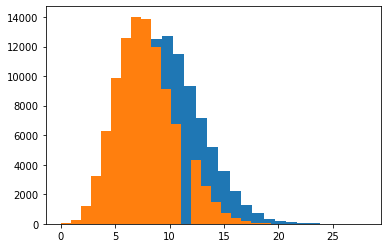

In [24]:
plt.hist(network_degree_clone,25)
plt.hist(network_degree_elder,25)

In [ ]:
plt.imshow(network_connection_elder, extent=[0, 100000, 0, 100000])
plt.show()

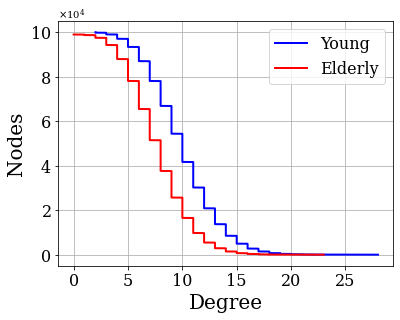

In [26]:
y_x = range(len(network_degree_clone))
y_y = sorted(network_degree_clone,reverse = True)

e_x = range(len(network_degree_elder))
e_y = sorted(network_degree_elder,reverse = True)

fig, ax = plt.subplots(figsize=(6, 4.5))

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Arial']
ax.plot(y_y,y_x,label = 'Young',linestyle='-',color = 'blue',linewidth= 2)
ax.plot(e_y,e_x,label = 'Elderly',linestyle='-',color = 'red',linewidth = 2)

ax.set_xlabel('Degree',fontsize= 20)
ax.set_ylabel('Nodes',fontsize= 20)
# ax.set_title('travel frequency vs infected ratio(N = 1000)',fontsize=32)
plt.ticklabel_format(useMathText= True, axis='y', scilimits=(4,4))
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
font_prop = font_manager.FontProperties(size = 16, weight = 4)
labels = ax.get_xticklabels() + ax.get_yticklabels()
ax.legend(prop = font_prop)
plt.grid()
plt.savefig(f'node_degree.png', dpi=500, bbox_inches='tight')

In [ ]:
print(network_degree_clone.sum()/network_degree_clone.shape[0])
print(network_degree_elder.sum()/network_degree_elder.shape[0])

In [ ]:
network_degree_elder

In [ ]:
plt.hist(network_degree_clone,25)
plt.hist(network_degree_elder,25)
